In [1]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)
spark.sparkContext.setLogLevel("FATAL")

21/07/29 11:15:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
from utility import *
import pyspark.sql.functions as F
from pyspark.sql import Window

In [3]:
# Read in AP Data
df_radio5 = spark.read.csv('neighbor_data/radio_5_neighbors.csv', header=True, inferSchema=True, sep="|").limit(100000)
df_radio5 = df_radio5.filter('erm__neighbors is not Null')
df_radio5.limit(5).toPandas()

,customer,id,erm__neighbors,erm__current_channel_usage__ibss,erm__current_channel_usage__obss,erm__current_channel_usage__interference,erm__current_channel_usage__noise_floor
0,3b2ed110-59d9-11e9-b2eb-097690af9635,E43ED7D07705,"[{""bssid"":""44FE3B5FB38A"",""ssid"":""SINGTEL-B388""...",3,1,12,-93
1,c45af140-2b6f-11ea-925c-cb4788700b86,F08620A246F6,"[{""bssid"":""A8D3F7935991"",""ssid"":""SINGTEL-5990""...",0,0,0,-96
2,5a4fe380-388d-11e9-88f4-6f9acfcffd90,D463FEE9EDBD,"[{""bssid"":""AC84C6AA038B"",""ssid"":""Tan"",""channel...",2,2,14,-93
3,e36e7de0-c350-11e9-ac21-ad5d367e4a53,488D3601041A,"[{""bssid"":""ECF451C31295"",""ssid"":""SINGTEL-1293""...",5,10,4,-94
4,540c3bc0-fc4d-11e9-a5b9-2f5c5fe06d2e,F086202D902C,"[{""bssid"":""CC32E5E9DD91"",""ssid"":"""",""channel"":4...",0,2,0,-95


In [4]:
# Filter Out bad data (remove alphabetical values in numerical column)
from pyspark.sql.functions import *

df_radio5 = df_radio5.filter(~F.col('erm__current_channel_usage__ibss').rlike('[a-zA-Z]'))
df_radio5 = df_radio5.filter(~F.col('erm__current_channel_usage__obss').rlike('[a-zA-Z]'))
df_radio5 = df_radio5.filter(~F.col('erm__current_channel_usage__interference').rlike('[a-zA-Z]'))

In [5]:
getNumericalValues(df_radio5, df_radio5.columns[3:])

,summary,erm__current_channel_usage__ibss,erm__current_channel_usage__obss,erm__current_channel_usage__interference,erm__current_channel_usage__noise_floor
0,count,62548,62548,62548,62548
1,mean,2.3644560977169533,5.753901004028906,4.79663618341114,-93.78419773613865
2,stddev,2.560879935685638,6.3329409402333825,7.9055785854120195,3.7183421592467574
3,min,0,0,0,-100
4,max,9,9,98,0


In [6]:
# Append neighbor_counts column to dataframe
from pyspark.sql.types import IntegerType
udf_get_neighbor_counts = F.udf(lambda neighbors: len(eval(neighbors)), IntegerType())
df_radio5 = df_radio5.withColumn('neighbor_counts', udf_get_neighbor_counts(F.col('erm__neighbors')))

In [7]:
# neighbors5 = list(df_radio5.select('erm__neighbors').toPandas()['erm__neighbors'])
# neighbors5 = [eval(neighbor) for neighbor in neighbors5]
# # for neighbor in neighbors5[0]:
# #     print(neighbor)
# neighbor_counts = [len(neighbor) for neighbor in neighbors5]

# neighbor_counts_col = spark.createDataFrame([(l,) for l in neighbor_counts], ['neighbor_counts'])
# df_radio5 = df_radio5.withColumn("row_idx", F.row_number().over(Window.orderBy(F.monotonically_increasing_id())))
# neighbor_counts_col = neighbor_counts_col.withColumn("row_idx", F.row_number().over(Window.orderBy(F.monotonically_increasing_id())))
# df_5 = df_radio5.join(neighbor_counts_col, df_radio5.row_idx == neighbor_counts_col.row_idx).drop("row_idx")
# df_5.limit(5).toPandas()

In [8]:
# Get customer values from csv files
import os
path = 'Updated_WiFi_2/'
id_list = []
fileList = os.listdir(path)
for f in fileList:
    df_wifi = spark.read.csv('{}{}'.format(path, f), header=True, inferSchema=True, sep=",", nanValue='', nullValue='')
    df_wifi = df_wifi.na.replace('No', None)
    df_wifi = df_wifi.filter('customer is not Null')
    ids = list(df_wifi.select('customer').toPandas()['customer'])
    id_list.extend(ids)



In [9]:
# id_list2 = list(df_radio5.select('customer').toPandas()['customer'])
# intersection_list = list(set.intersection(set(id_list), set(id_list2)))

In [63]:
# Add label column
from pyspark.sql.types import IntegerType
def checkID(id):
    return 1 if id in id_list else 0
        
udf_get_label = F.udf(lambda id: checkID(id), IntegerType())
df_radio5 = df_radio5.withColumn('label', udf_get_label(F.col('customer')))

In [64]:
getColumnCounts(df_radio5, 'label')

,label,count
0,1,1459
1,0,61089


In [12]:
df_5 = df_radio5

In [13]:
# Drop unnecessary columns as clustering only takes in numerical features
cols_to_drop = ['id', 'erm__neighbors']
df_5 = df_5.drop(*cols_to_drop)
df_5.printSchema()

root
 |-- customer: string (nullable = true)
 |-- erm__current_channel_usage__ibss: string (nullable = true)
 |-- erm__current_channel_usage__obss: string (nullable = true)
 |-- erm__current_channel_usage__interference: string (nullable = true)
 |-- erm__current_channel_usage__noise_floor: string (nullable = true)
 |-- neighbor_counts: integer (nullable = true)
 |-- label: integer (nullable = true)



In [14]:
# Cast String columns to Integer so clustering works
from pyspark.sql.types import IntegerType
for str_column in df_5.columns[1:]:
    df_5 = df_5.withColumn(str_column, F.col(str_column).cast(IntegerType()))

In [15]:
df_5.printSchema()

root
 |-- customer: string (nullable = true)
 |-- erm__current_channel_usage__ibss: integer (nullable = true)
 |-- erm__current_channel_usage__obss: integer (nullable = true)
 |-- erm__current_channel_usage__interference: integer (nullable = true)
 |-- erm__current_channel_usage__noise_floor: integer (nullable = true)
 |-- neighbor_counts: integer (nullable = true)
 |-- label: integer (nullable = true)



In [16]:
# correlatedFeatures = getCorrelation(df_5, df_5.columns, threshold=1)

In [17]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator

feature_columns = df_5.columns[1:-1]

assembler = VectorAssembler(inputCols = feature_columns, outputCol = "features")
scaler = StandardScaler(inputCol='features',outputCol='scaled_features')
minmaxScaler = MinMaxScaler(inputCol='features',outputCol='scaled_features')

kmeans = KMeans(featuresCol='scaled_features', k=2)

pipeline = Pipeline(stages=[assembler, minmaxScaler])
pipelineModel = pipeline.fit(df_5)

scaledDF = pipelineModel.transform(df_5)

kmModel = kmeans.fit(scaledDF)
results = kmModel.transform(scaledDF)

In [18]:
results.limit(5).toPandas()

,customer,erm__current_channel_usage__ibss,erm__current_channel_usage__obss,erm__current_channel_usage__interference,erm__current_channel_usage__noise_floor,neighbor_counts,label,features,scaled_features,prediction
0,3b2ed110-59d9-11e9-b2eb-097690af9635,3,1,12,-93,43,0,"[3.0, 1.0, 12.0, -93.0, 43.0]","[0.038461538461538464, 0.015384615384615385, 0...",0
1,c45af140-2b6f-11ea-925c-cb4788700b86,0,0,0,-96,13,0,"(0.0, 0.0, 0.0, -96.0, 13.0)","(0.0, 0.0, 0.0, 0.12727272727272726, 0.0470588...",0
2,5a4fe380-388d-11e9-88f4-6f9acfcffd90,2,2,14,-93,101,0,"[2.0, 2.0, 14.0, -93.0, 101.0]","[0.02564102564102564, 0.03076923076923077, 0.1...",1
3,e36e7de0-c350-11e9-ac21-ad5d367e4a53,5,10,4,-94,63,0,"[5.0, 10.0, 4.0, -94.0, 63.0]","[0.0641025641025641, 0.15384615384615385, 0.04...",0
4,540c3bc0-fc4d-11e9-a5b9-2f5c5fe06d2e,0,2,0,-95,37,0,"[0.0, 2.0, 0.0, -95.0, 37.0]","[0.0, 0.03076923076923077, 0.0, 0.136363636363...",0


In [19]:
results.groupBy('prediction').count().toPandas() 

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


,prediction,count
0,1,13436
1,0,49112


In [20]:
cluster0 = filterDataFrame(results, ['prediction == 0'])
cluster1 = filterDataFrame(results, ['prediction == 1'])

In [21]:
cluster0.groupBy('label').count().toPandas() 

,label,count
0,1,1147
1,0,47965


In [22]:
cluster1.groupBy('label').count().toPandas() 

,label,count
0,1,312
1,0,13124


In [23]:
getNumericalValues(cluster0, cluster0.columns[1:-3])

,summary,erm__current_channel_usage__ibss,erm__current_channel_usage__obss,erm__current_channel_usage__interference,erm__current_channel_usage__noise_floor,neighbor_counts,label
0,count,49112,49112,49112,49112,49112,49112
1,mean,1.7496131291741326,3.6595536732366836,3.551820329043818,-94.0847857957322,35.317396970190586,0.023354780908942826
2,stddev,2.1963723474069234,3.873595101180652,6.469268966863286,3.5587751567483425,23.348354505660158,0.15102913481234068
3,min,0,0,0,-110,1,0
4,max,78,52,100,0,103,1


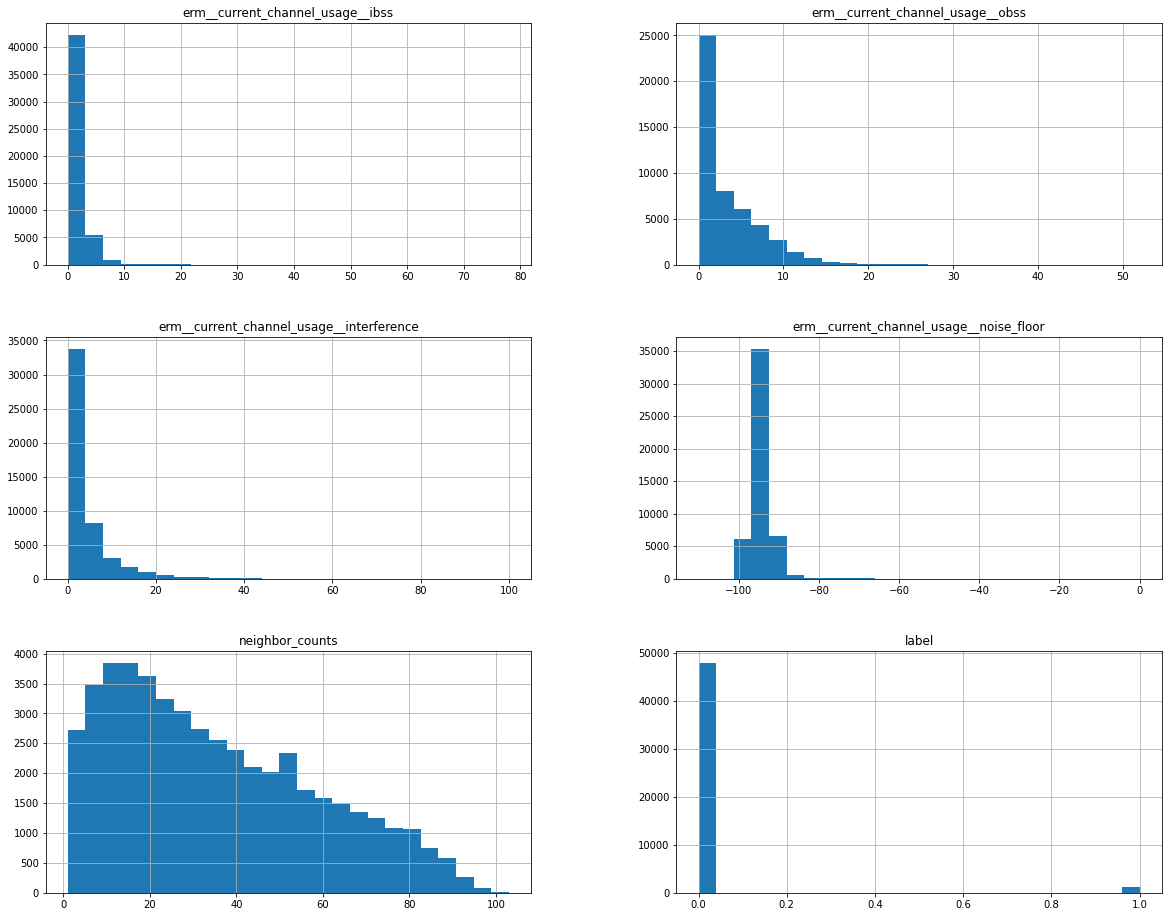

In [24]:
# graphNumericalFeatures(cluster0, cluster0.columns[1:-3])

In [25]:
getNumericalValues(cluster1, cluster1.columns[1:-3])

,summary,erm__current_channel_usage__ibss,erm__current_channel_usage__obss,erm__current_channel_usage__interference,erm__current_channel_usage__noise_floor,neighbor_counts,label
0,count,13436,13436,13436,13436,13436,13436
1,mean,4.6118636498958026,13.40927359333135,9.346754986603155,-92.68547186662697,143.9842959214052,0.02322119678475737
2,stddev,2.542484110275146,7.564575760686893,10.564391209689608,4.06622516976761,48.77711984020958,0.15061095936055086
3,min,0,0,0,-101,41,0
4,max,26,65,100,0,256,1


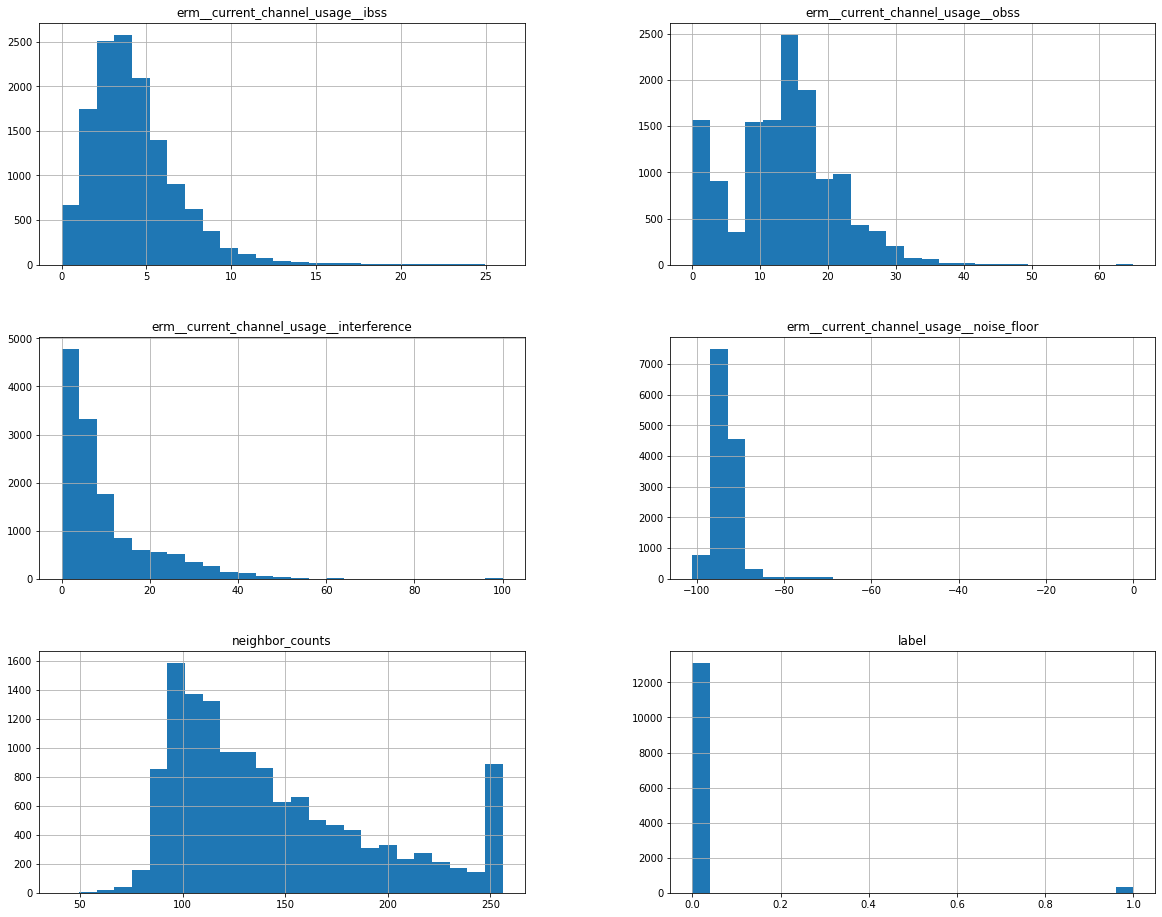

In [26]:
# graphNumericalFeatures(cluster1, cluster1.columns[1:-3])

In [27]:
pdCluster0 = cluster0.select(cluster0.columns[1:-3]).toPandas()
pdCluster1 = cluster1.select(cluster1.columns[1:-3]).toPandas()

/var/folders/yn/m0pbsyzn6kz3jdnb9f75twwr0000gp/T/ipykernel_23838/2061482147.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png') #svg


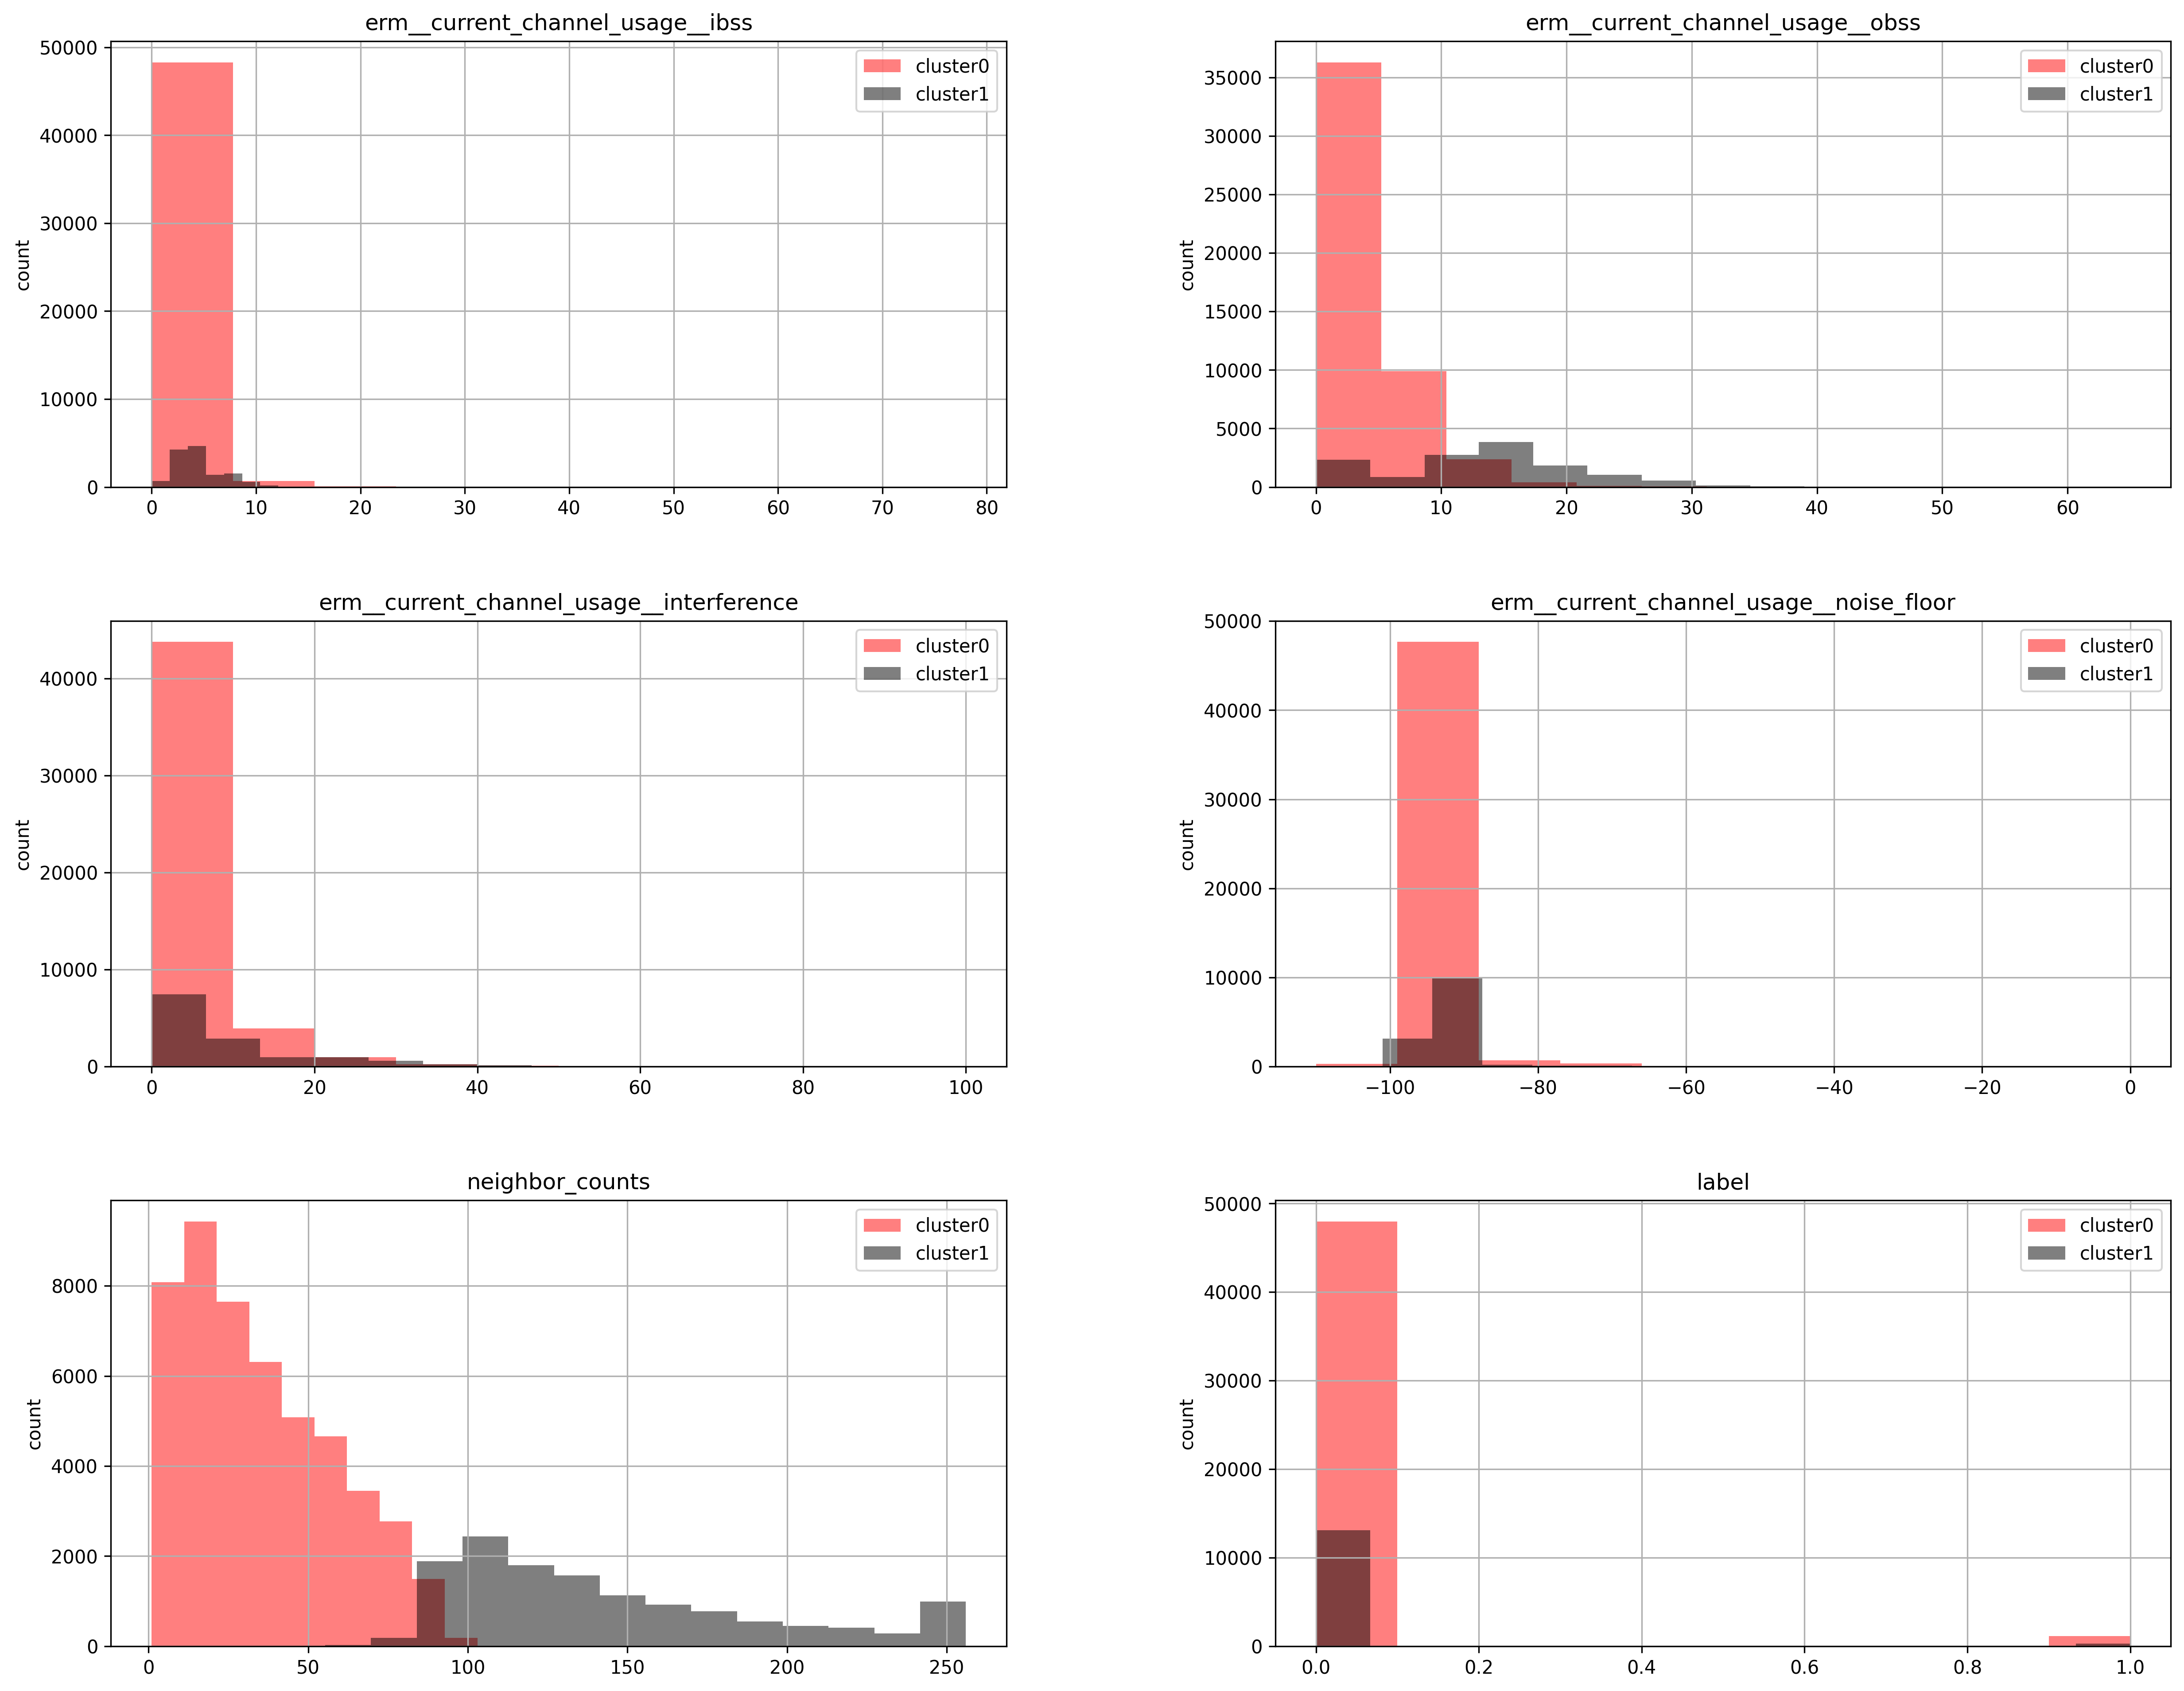

In [68]:
# Plot historgams for each cluster ontop of each other to see patters
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png') #svg
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

labels = ['cluster0', 'cluster1']
colors = ['r', 'k']
alphalevel = 0.5
binSize = 15
figureSize = (20, 16)

hist = pdCluster0.hist(alpha = alphalevel, color = colors[0])
for ax, (colname, values) in zip(hist.flat, pdCluster1.iteritems()):
    values.hist(ax=ax, bins=binSize, figsize = figureSize, alpha = alphalevel, color = colors[1])
    ax.legend(labels)
    ax.set_ylabel('count')  

#

In [66]:
# Get intersecting values for each column
intersection_lists = []
for c in df_5.columns[1:-1]:
    c0 = pdCluster0[c].to_list()
    c1 = pdCluster1[c].to_list()
    intersection = list(set(c0) & set(c1))
    print(c, intersection)
    intersection_lists.append(intersection)

erm__current_channel_usage__ibss [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26]
erm__current_channel_usage__obss [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 41, 43, 46, 47, 52]
erm__current_channel_usage__interference [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 65, 68, 73, 77, 80, 81, 86, 87, 100]
erm__current_channel_usage__noise_floor [0, -101, -100, -99, -98, -97, -96, -95, -94, -93, -92, -91, -90, -89, -88, -87, -86, -85, -84, -83, -82, -81, -80, -79, -78, -77, -76, -75, -74, -73, -72, -71, -70, -69, -68, -67, -66, -65, -64, -62, -22, -21, -19]
neighbor_counts [41, 44, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72

In [26]:
# Determine optimal k value used for clustering
silhouette_score = []
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled_features', metricName='silhouette', distanceMeasure='squaredEuclidean')

for k in range(2,10):
    
    kmeans = KMeans(featuresCol='scaled_features', k=k)
    kmModel = kmeans.fit(scaledDF)
    output = kmModel.transform(scaledDF)
    
    score = evaluator.evaluate(output)
    silhouette_score.append(score)
    
    print(k, "Silhouette Score:",score)

2 Silhouette Score: 0.7348019738850334


3 Silhouette Score: 0.6028783803130301


4 Silhouette Score: 0.4890319418929865


5 Silhouette Score: 0.5075697594404374


6 Silhouette Score: 0.44196112721697434


7 Silhouette Score: 0.4380983539859836


8 Silhouette Score: 0.4539224850363054


9 Silhouette Score: 0.4258154549610285


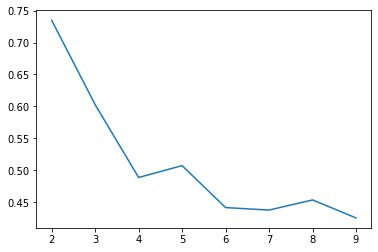

In [27]:
# Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
plt.plot(range(2,10),silhouette_score)

In [60]:
# Export Cluster Data as csv

cluster0.drop(*['features', 'scaled_features']).toPandas().to_csv('neighbors_5_cluster0.csv')
cluster1.drop(*['features', 'scaled_features']).toPandas().to_csv('neighbors_5_cluster1.csv')